In [21]:
pip install transformers torch scikit-learn nltk fastapi uvicorn nest_asyncio


# Create CustomTokenizer using TF_ID
CustomTokenizer class that preprocesses log entries and tokenizes them using a TF-IDF vectorizer.
    

In [2]:
import os
import glob
import nltk
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import pickle


'''
Function: read_logs
Objective: This function reads log entries from log files in the current directory
Input: file_list (optional). List of log files to read. 
    If None, all log files in the current directory will be read.
Output: log_entries. List of log entries read from the log files.
'''
def read_logs(file_list=None):
    log_entries = []
    directory = os.getcwd()  # Get the current working directory
    if file_list is None:
        file_paths = glob.glob(os.path.join(directory, "*.jrn"))
    else:
        file_paths = [os.path.join(directory, file) for file in file_list]
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            log_entries.extend(lines)
    return log_entries


''' 
    CustomTokenizer class that preprocesses log entries and tokenizes them using a TF-IDF vectorizer 
    The class provides methods to fit, transform, and fit_transform log entries
    The class also provides a method to save the custom tokenizer to a file
'''
class CustomTokenizer:
    def __init__(self, vectorizer):
        nltk.download('punkt')
        self.vectorizer = vectorizer

    '''
        Function: preprocess_logs
        Objective: This function preprocesses log entries by removing timestamps, operation codes, special characters, and numbers.
                It also tokenizes the log entries into words and filters out non-readable words.
        Input: log_entries. List of log entries to preprocess.
        Output: processed_logs. List of preprocessed log entries.
    '''
    def __preprocess(self, log_entries):
        processed_logs = []
        for entry in log_entries:
            entry = entry.strip().replace("\n", "")
            entry = re.sub(r"^\s*\d{2}:\d{2}:\d{2}\s+\d+\s+", "", entry)
            entry = re.sub(r"\d{2,}", "", entry)
            entry = re.sub(r"[<>{}()\[\]]", "", entry)
            entry = re.sub(r'\\[0-9A-Za-z]+', '', entry)
            words = word_tokenize(entry)
            readable_words = [word for word in words if word.isalpha() and len(word) > 4]
            if len(readable_words) > 0:
                processed_entry = " ".join(readable_words)
                processed_logs.append(processed_entry)
        return processed_logs

    def fit(self, log_entries):
        processed_entries = self.__preprocess(log_entries)
        self.vectorizer.fit(processed_entries)
        
    def transform(self, log_entries):
        processed_entries = self.__preprocess(log_entries)
        return self.vectorizer.transform(processed_entries)
    
    def fit_transform(self, log_entries):
        processed_entries = self.__preprocess(log_entries)
        return self.vectorizer.fit_transform(processed_entries)
    
    def save(self, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(self, file)
    



# This section is about converting text data to numerical format using TF-IDF and splitting the data into training and testing sets.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Read log entries from log files
log_entries = read_logs()

# Convert processed log entries to numerical format using TF-IDF. This is sort of normalization
# for text data. TF-IDF Vectorizer using 4-grams
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(4, 4))
custom_tokenizer = CustomTokenizer(vectorizer)
log_data_transformed = custom_tokenizer.fit_transform(log_entries)

# Split the data into training and testing sets
train_data, test_data = train_test_split(log_data_transformed, test_size=0.2, random_state=42)
train_data = train_data.toarray()
test_data = test_data.toarray()

# Save the custom tokenizer to a file
custom_tokenizer.save("custom_tokenizer.pkl")






[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Autoencoder Architecture 


Each layer reduces the dimensionality, allowing the model to learn a compressed representation of the data.

The sigmoid activation function is  used in the output layer of an autoencoder when the goal is to reconstruct data scaled between 0 and 1.  The sigmoid function outputs values between 0 and 1, which matches the range of the TF-IDF features used in the conversion oif text data to numerical data. Also, it introduces non-linearity, enabling the model to capture complex patterns

In an autoencoder, the latent space is the layer in the middle of the network that represents the compressed knowledge of the input data. It is the output of the encoder part of the network and serves as the input to the decoder part.  It could be seen as a sort of **embeddings**

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

input_dim = train_data.shape[1]

# Define the encoder
encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu', name='latent_space')  # Latent space layer
])

# Define the decoder
decoder = Sequential([
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

# Combine encoder and decoder into an autoencoder
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
autoencoder.summary()
# Print the encoder summary
encoder.summary()
# Print the decoder summary
decoder.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       932,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,736 (3.56 MB)

 Trainable params: 932,736 (3.56 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       768,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,736 (3.56 MB)

 Trainable params: 932,736 (3.56 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 199s 16ms/step - loss: 0.0025 - val_loss: 4.1685e-04
Epoch 2/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 170s 14ms/step - loss: 4.1622e-04 - val_loss: 4.1685e-04
Epoch 3/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 4.1683e-04 - val_loss: 4.1685e-04
Epoch 4/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 124s 10ms/step - loss: 4.1725e-04 - val_loss: 4.1685e-04
Epoch 5/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 124s 10ms/step - loss: 4.1621e-04 - val_loss: 4.1685e-04
Epoch 6/10
12096/12096 ━━━━━━━━━━━━━━━━━━━━ 125s 10ms/step - loss: 4.1638e-04 - val_loss: 4.1685e-04


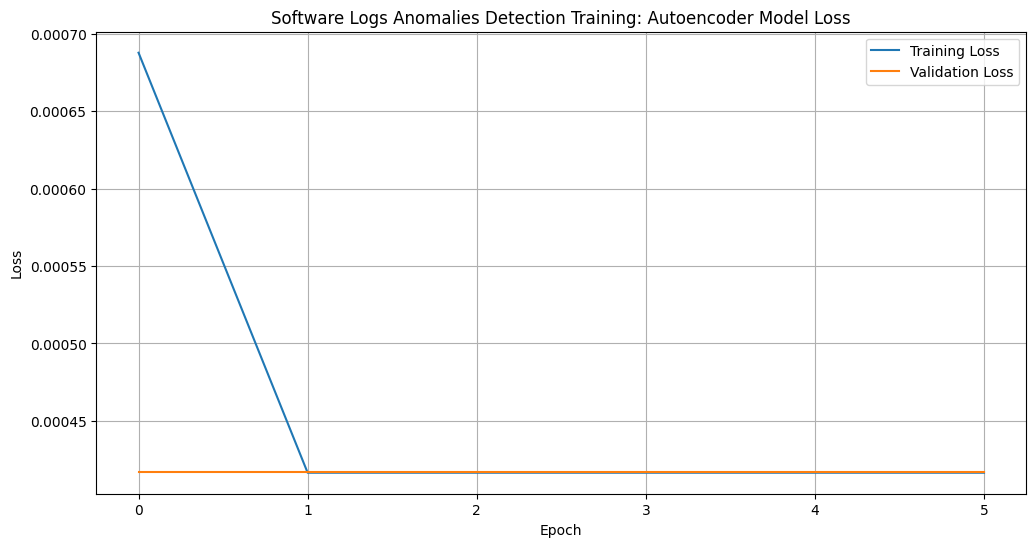

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = autoencoder.fit(
    train_data, 
    train_data, 
    epochs=10, 
    batch_size=64, 
    shuffle=True, 
    validation_split=0.1, 
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Software Logs Anomalies Detection Training: Autoencoder Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Model Convergence: The model converges quickly, as indicated by the rapid decrease in training loss.
Generalization: The close and stable validation loss suggests good generalization without overfitting.
Possible Early Stopping: You might not need many epochs for training since the loss stabilizes early.

# Detect Anomalies in Train Data
Use the reconstruction error to identify anomalies:

26880/26880 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step


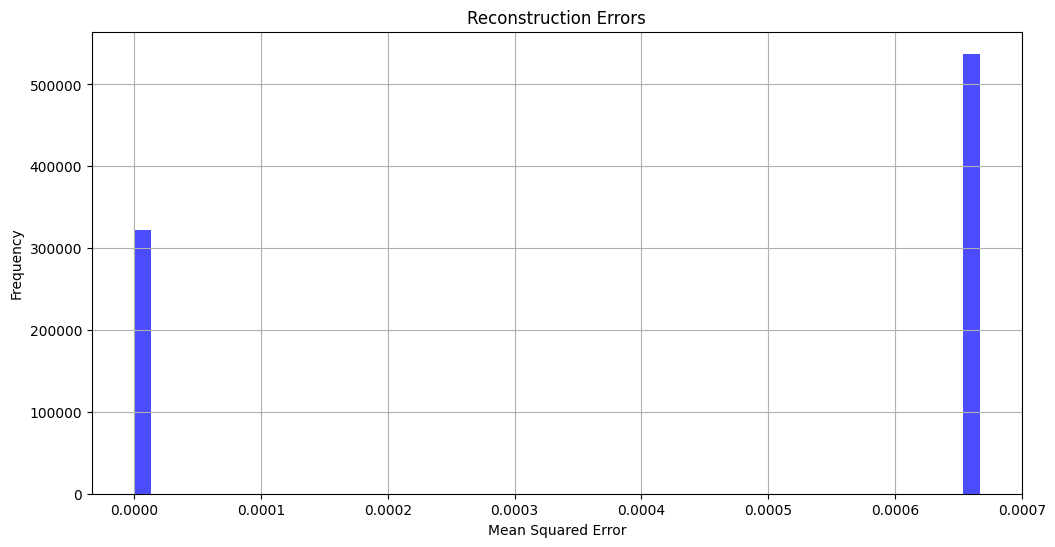

In [4]:
import numpy as np
autoencoder = tf.keras.models.load_model('autoencoder_model.keras')
reconstructed_data = autoencoder.predict(train_data)
reconstruction_errors = np.mean(np.square(train_data - reconstructed_data), axis=1)
# Histogram of reconstruction_errors
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.title('Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [5]:
threshold = np.percentile(reconstruction_errors, 95)
threshold
anomalies = np.where(reconstruction_errors > threshold)[0]

print("Threshold:", threshold)
print("Anomalous log entries:")
for idx in anomalies:
    print(idx, log_entries[idx])


Threshold: 0.0006666666666666666
Anomalous log entries:
451  13:06:30  5070 <CashOut Agent> CASH COUNTERS (S) 

990                               operational: EPP

1005  09:19:24  1016 <Application> Opening customer service...

1157 

1657  10:43:10  5011 <Error Mgr> State of (optional) device MONEY_CASSETTE_1 (BIN1,USD,10000) changed to: OPERATIONAL (1)  

1910  11:31:36  5000 <Error Mgr> CCJournalAgent successfully started 

2020 

2953  11:56:58  41005 <CCProtFW1> Received raw message : 3\1c\1c\1c11\1c090\0fACSELECT THE TO ACCOUNT BY PRESSING\0fBHTHE CORRECT NUMBER KEY\0fO;PROCEED\0fOV\0e097\0d\0f2<CANCEL\0fLESELECTION: \1c102\1b;0"Please take your card."000000\0fHIPLEASE TAKE YOUR CARD\0fGP\1c103\1b;0"Please take your card and your receipt."000000\0fHIPLEASE TAKE YOUR CARD\0fINAND RECEIPT\0fK<\1c104\1b;0"Your card has been retained."000000\0fHFYOUR CARD HAS BEEN RETAINED\0fHT\1c105\1b;0"Do you want another transaction?"000000\0fFIDO YOU WANT TO PERFORM\0fGJANOTHER TRANSACTION?\0e10

# Visualization of Latent Space        

26880/26880 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step


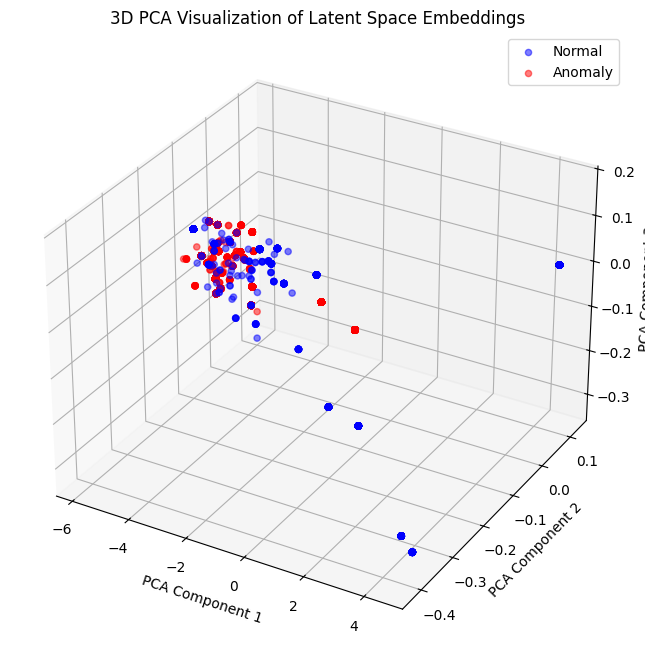

In [20]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Extract embeddings from the latent space
autoencoder = tf.keras.models.load_model('autoencoder_model.keras')
latent_space_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_space').output)
latent_space_embeddings = latent_space_model.predict(train_data)

# PCA in 3D
pca = PCA(n_components=3)
pca_embeddings_3d = pca.fit_transform(latent_space_embeddings)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal and anomalous data points
ax.scatter(pca_embeddings_3d[~anomalies, 0], pca_embeddings_3d[~anomalies, 1], pca_embeddings_3d[~anomalies, 2], 
           c='b', label='Normal', alpha=0.5)
ax.scatter(pca_embeddings_3d[anomalies, 0], pca_embeddings_3d[anomalies, 1], pca_embeddings_3d[anomalies, 2], 
           c='r', label='Anomaly', alpha=0.5)

ax.set_title('3D PCA Visualization of Latent Space Embeddings')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()

In [10]:
latent_space_embeddings.shape
anomalies

array([   451,    990,   1005, ..., 859571, 859826, 860086], dtype=int64)

# Inference in test data

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\log_analytics\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6720/6720 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


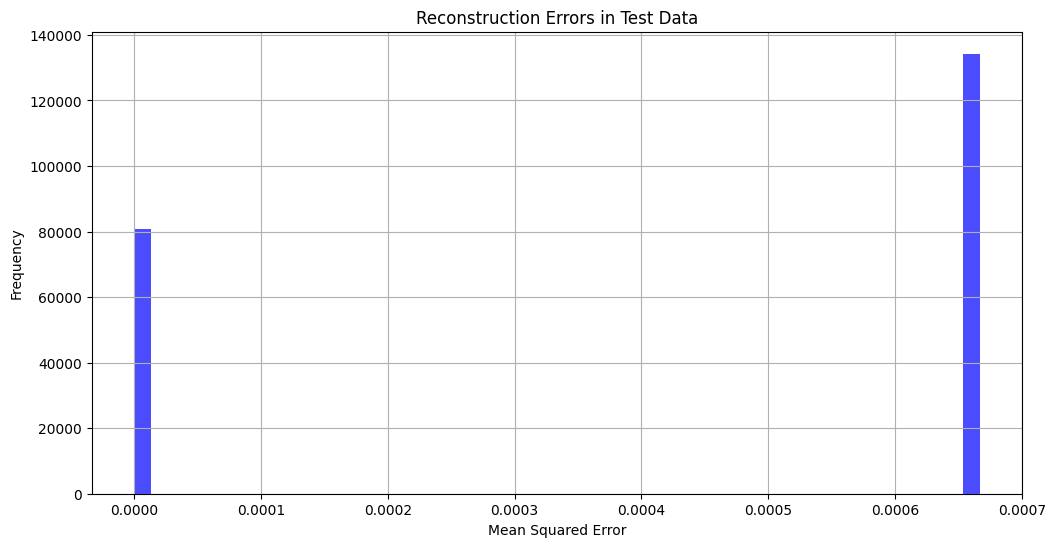

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt

# Load the autoencoder model
autoencoder = tf.keras.models.load_model('autoencoder_model.keras')
reconstructed_data=autoencoder.predict(test_data)

reconstruction_errors = np.mean(np.square(test_data - reconstructed_data), axis=1)
# Histogram of reconstruction_errors
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.title('Reconstruction Errors in Test Data')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [22]:
threshold=0.0006666666666666666
anomalies = np.where(reconstruction_errors > threshold)[0]

print("Threshold:", threshold)
print("Anomalous log entries:")
for idx in anomalies:
    print(idx, log_entries[idx])

Threshold: 0.0006666666666666666
Anomalous log entries:
448  13:06:26  41004 <CCProtFW1> Sent raw message     : 12\1c000FB0017\1c\1c20:\1c000AL01:3F:90:00 

939  09:18:37  5021 <CashOut Agent> MONEY_CASSETTE_4 (BIN4,USD,500): MONEY state is EMPTY   

1287  10:04:30  1021 <Application> SERVICE FW is ready!

1950  11:31:54  5010 <Error Mgr> Device state (optional ) MONEY_CASSETTE_2 (BIN2,USD,2000)  is: OPERATIONAL (1) 

2124  11:44:28  5000 <Error Mgr> CCGuiAgent successfully started 

2233                               operational: EPP

3013  11:58:01  1002 <Application> Operator mode start

3119  12:16:01  41005 <CCProtFW1> Received raw message : 1\1c\1c\1c1 

3333  15:19:01  5010 <Error Mgr> Device state (optional ) MONEY_CASSETTE_1 (BIN1,USD,10000) is: OPERATIONAL (1) 

3890  16:07:19  41005 <CCProtFW1> Received raw message : 3\1c\1c\1c12\1c431SC 001075432312000\1c432SC 001073000000077341312312312312312312\1c450@F 100097001048048048\1c200D040111044000066000000000\1c201D04011101203206

In [8]:
print(test_data.shape)
print(train_data.shape)
#latent_space_embeddings = latent_space_model.predict(test_data)

(215033, 1500)
(860132, 1500)


6720/6720 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


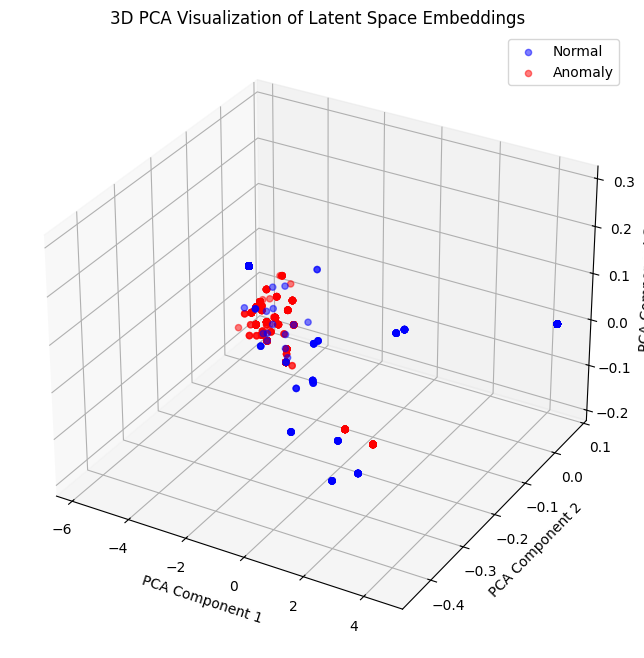

In [29]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Extract embeddings from the latent space
latent_space_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_space').output)
latent_space_embeddings = latent_space_model.predict(test_data)

# PCA in 3D
pca = PCA(n_components=3)
pca_embeddings_3d = pca.fit_transform(latent_space_embeddings)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal and anomalous data points
ax.scatter(pca_embeddings_3d[~anomalies, 0], pca_embeddings_3d[~anomalies, 1], pca_embeddings_3d[~anomalies, 2], 
           c='b', label='Normal', alpha=0.5)
ax.scatter(pca_embeddings_3d[anomalies, 0], pca_embeddings_3d[anomalies, 1], pca_embeddings_3d[anomalies, 2], 
           c='r', label='Anomaly', alpha=0.5)

ax.set_title('3D PCA Visualization of Latent Space Embeddings')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()


# FASTAPI to create and inference endpoint

Serialize autoencoder model to be used in production



In [1]:
autoencoder.save('autoencoder_model.keras')
custom_tokenizer.save("custom_tokenizer.pkl")

# Inference endpoint with FastApi

In [30]:
from fastapi import FastAPI
from tensorflow.keras.models import load_model
import pickle
import numpy as np
import uvicorn
import nest_asyncio

# Apply nest_asyncio to allow the event loop to run in Jupyter
nest_asyncio.apply()
app = FastAPI()

threshold = 0.0006666666666666666  # Set the threshold for anomaly detection
# Load the autoencoder model
autoencoder = tf.keras.models.load_model('autoencoder_model.keras')

# Load the custom tokenizer
with open('custom_tokenizer.pkl', 'rb') as file:
    custom_tokenizer = pickle.load(file)

@app.post("/predict/")
async def predict(log_entry: str):
    # Preprocess the log entry and convert it to a numerical format
    log_entry_vectorized = custom_tokenizer.transform([log_entry]).toarray()
    
    # Make a prediction using the autoencoder model
    reconstructed_data = autoencoder.predict(log_entry_vectorized)
    reconstruction_error = np.mean(np.square(log_entry_vectorized - reconstructed_data))
    
    # Determine if the log entry is an anomaly based on the reconstruction error
    is_anomaly = reconstruction_error > threshold
    
    return {"reconstruction_error": reconstruction_error, "is_anomaly": is_anomaly}


if __name__ == "__main__":
    config = uvicorn.Config(app, host="127.0.0.1", port=8000, log_level="info")
    server = uvicorn.Server(config)
    try:
        server.run()
    except KeyboardInterrupt:
        server.should_exit = True

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\log_analytics\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
INFO:     Started server process [16356]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [16356]


# Visualization anomalities in test-data using TensorBoard

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input, Dense
import os
from datetime import datetime
from tensorboard.plugins import projector

# Load the autoencoder model
autoencoder = tf.keras.models.load_model('autoencoder_model.keras')

# Extract the latent space model
latent_space_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_space').output)
latent_space_embeddings = latent_space_model.predict(test_data)

log_dir = os.path.join("logs", "fit")
print("TensorBoard log directory:", log_dir)


# Save the embeddings and metadata
embeddings_file = os.path.join(log_dir, 'latent_space_embeddings.tsv')
metadata_file = os.path.join(log_dir, 'metadata.tsv')

# Save the embeddings and metadata
embeddings_file = os.path.join(log_dir, 'latent_space_embeddings.tsv')
metadata_file = os.path.join(log_dir, 'metadata.tsv')

np.savetxt(embeddings_file, latent_space_embeddings, delimiter='\t')

with open(metadata_file, 'w') as f:
    f.write("log_entry\tis_anomaly\n")
    for idx in range(len(test_data)):
        is_anomaly = 'yes' if idx in anomalies else 'no'
        f.write(f"{log_entries[idx].replace("\n", "").replace("\t", "")}\t{is_anomaly}\n")
      
# Configure the projector
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = 'latent_space_embeddings'
embedding.metadata_path = metadata_file

# Save the configuration file
projector.visualize_embeddings(log_dir, config)


# Launch TensorBoard
# Run the following command in your terminal:
# tensorboard --logdir=logs/fit


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\log_analytics\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6720/6720 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
TensorBoard log directory: logs\fit
